# Solving a superconducting system

In the following tutorial we will use the fermionic operators in order to solve the Hamiltonian of a superconducting system. We will find the fundamental state and study some properties. 

The system considered will have 2$\Omega$ modes and $\Omega$ particles. It will be structured as $\Omega$ levels of energy, each with a double degeneracy $k$ and $\bar{k}$ (picture two parallel columns). Different levels will interact with a pairing term described below.

After finding this state, we can measure some correlation functions. For more information about this problem, you can refer to [this work](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.062109).

In [1]:
using Fermionic
using SparseArrays
using LinearAlgebra
using Plots

## Index

We will solve this problem in many different ways, both analytical and numerical, with and without the aid of symmetries.

1. [Find the fundamental state](#fundamental) (fixed g)
2. [One body entropy](#ssp) (as a function of g)
3. [Using fixed number](#fixed) (faster)
4. [Analytical solution](#symbol) (symbolic results)
5. [Using symmetries](#sym) (even faster)
6. [States from symmetries](#states) (for further studies)

<a id='fundamental'></a>
## Hamiltonian:
The complete Hamiltonian has both a free and an interaction term:

$H=\sum_k \epsilon_k (c_k^\dagger c_k + c_{\bar{k}}^\dagger c_{\bar{k}})-\sum_{k,k'} G_{k,k'} c_{k'}^\dagger c_{\bar{k'}}^\dagger c_{\bar{k}} c_k$

#### Free term
$H_0 = \sum_k \epsilon_k (c_k^\dagger c_k + c_{\bar{k}}^\dagger c_{\bar{k}})$

Levels $k$ and $\bar{k}$ have the same energy (this is the degeneracy). We will consider an equally spaced spectrum, i.e. $\epsilon_k = \epsilon_0\quad \forall k$ (this can be easily changed in the code).

In [2]:
o = Op(4); #this is for dimension 4
e0 = 1.0 #the energy spectrum of the free term
d = dim(o) 
epsilon = [e0*(i-d/4-1/2) for i in 1:d/2]
epsilon = sort([epsilon; epsilon])

h0 = sum([epsilon[i]*(cdm(o,i)*cm(o,i) + cdm(o,i+1)*cm(o,i+1)) for i in 1:2:(Int(d)-1)])

16×16 SparseMatrixCSC{Float64,Int64} with 10 stored entries:
  [2 ,  2]  =  0.5
  [3 ,  3]  =  0.5
  [4 ,  4]  =  1.0
  [5 ,  5]  =  -0.5
  [8 ,  8]  =  0.5
  [9 ,  9]  =  -0.5
  [12, 12]  =  0.5
  [13, 13]  =  -1.0
  [14, 14]  =  -0.5
  [15, 15]  =  -0.5

#### Interaction
$H_I = \sum_{k,k'} G_{k,k'} c_{k'}^\dagger c_{\bar{k'}}^\dagger c_{\bar{k}} c_k$

This term activates when both $k$ and $\bar{k}$ modes are occupied. The fundamental state wants to activate this term, because it is negative in the total Hamiltonian. So we expect a state where modes $k$ and $\bar{k}$ are equally occupied.

In [3]:
using SparseArrays
g = 1
hi = sum([sum([if i==j spzeros(2^d, 2^d) else g*(cdm(o,j)*cdm(o,j+1)*cm(o,i+1)*cm(o,i)) end
                    for i in 1:2:(Int(d)-1)]) for j in 1:2:(Int(d)-1)])

16×16 SparseMatrixCSC{Float64,Int64} with 2 stored entries:
  [13,  4]  =  1.0
  [4 , 13]  =  1.0

In [4]:
println(Matrix(basis(o))[4,:])
println(Matrix(basis(o))[13,:])

[0.0, 0.0, 1.0, 1.0]
[1.0, 1.0, 0.0, 0.0]


We now finde the fundamental state

In [5]:
using LinearAlgebra
h = h0 - hi
eigvecs(Matrix(h))[:,1]

16-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.38268343236508984
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.9238795325112866
 0.0
 0.0
 0.0

Here is the full code:

In [6]:
d = 8 #este va a ser un sistema de 4 niveles
o = Op(d);

e0 = 1.0
g = 5.0

epsilon = [2*e0*(i-d/4-1/2) for i in 1:d/2]
epsilon = sort([epsilon; epsilon])
h0 = sum([epsilon[i]*(cdm(o,i)*cm(o,i) + cdm(o,i+1)*cm(o,i+1)) for i in 1:2:(Int(d)-1)])


hi = sum([sum([if i==j spzeros(2^d, 2^d) else g*(cdm(o,j)*cdm(o,j+1)*cm(o,i+1)*cm(o,i)) end
                    for i in 1:2:(Int(d)-1)]) for j in 1:2:(Int(d)-1)])
    
h = h0 - hi
fundamental = eigvecs(Matrix(h))[:,1]
fund = State(fundamental,o);

We can now use the built in functions (like the one body entropy) or the use our own for studying this state.

In [7]:
eigensp(fund)

8-element Array{Float64,1}:
 0.688488188313256
 0.688488188313256
 0.575317665651686
 0.575317665651686
 0.424682334348314
 0.424682334348314
 0.311511811686744
 0.311511811686744

Notice: We never specified that this state is in the half filled case, but it happens to be that ammong all possible occupancies, that is exactly the one that gives the fundamental state.

<a id='ssp'></a>
## One body entropy as a function of g

In [8]:
d = 8
o = Op(d);

e0 = 1.0
gmin = 0.0
gmax = 6
step = 0.01


epsilon = [2*e0*(i-d/4-1/2) for i in 1:d/2]
epsilon = sort([epsilon; epsilon])
h0 = sum([epsilon[i]*(cdm(o,i)*cm(o,i) + cdm(o,i+1)*cm(o,i+1)) for i in 1:2:(Int(d)-1)])
hi = sum([sum([if i==j spzeros(2^d, 2^d) else (cdm(o,j)*cdm(o,j+1)*cm(o,i+1)*cm(o,i)) end
            for i in 1:2:(Int(d)-1)]) for j in 1:2:(Int(d)-1)]) 
g = zeros(0)
entropy = zeros(0)

for k in gmin:step:gmax
    append!(g,round(k, digits=10))
    h = h0 - round(k, digits=10)*hi
    fundamental = eigvecs(Matrix(h))[:,1]
    fund = State(fundamental,o);
    append!(entropy,ssp(fund))
    #print(round(k, digits=10)) si quiero ver el progreso
end


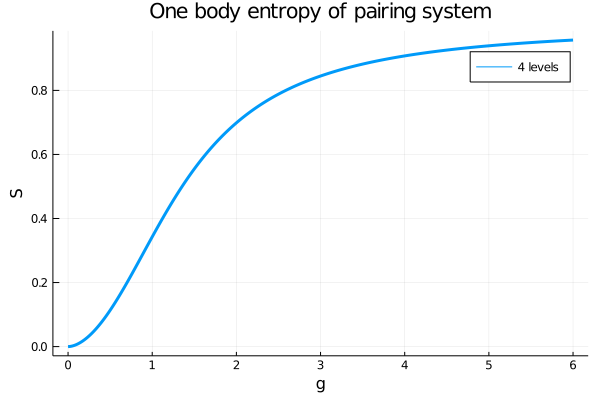

In [9]:
plot(g, entropy, title = "One body entropy of pairing system", label = "4 levels", lw = 3, xlabel = "g", ylabel = "S")

<a id='fixed'></a>
## Fixed number


We can reduce the basis to only work with a fixed fermionic number, and hence reduce the dimensionality from $2^d\times 2^d$ to $\binom{d}{n}\times \binom{d}{n}$. This is really useful for systems with fixed fermionic number, such as a superconducting hamiltonian. By reducing the dimensionalty, it becomes much more efficient, specially for greater dimensions. We will use the cdc() operators with already defined basis.

In [10]:
using Fermionic
using SparseArrays
using LinearAlgebra

d = 8 #this will be a system of 4 levels
nume = Int(d/2)

e0 = 1.0
g = 5.0

b, index = basis_m(d,nume)

epsilon = [2*e0*(i-d/4-1/2) for i in 1:d/2]
epsilon = sort([epsilon; epsilon])
h0 = sum([epsilon[i]*(cdc(b,index,i,i) + cdc(b,index,i+1,i+1)) for i in 1:2:(Int(d)-1)])
hi = sum([sum([if i==j spzeros(binomial(d,nume), binomial(d,nume)) else -g*(cdc(b,index,j,i+1)*cdc(b,index,j+1,i)) end
                    for i in 1:2:(Int(d)-1)]) for j in 1:2:(Int(d)-1)])
h = h0 - hi
fundamental = eigvecs(Matrix(h))[:,1];
fundamental = [round(fundamental[i], digits=15) for i in 1:binomial(d,nume)]
fundamental = fundamental/sqrt(fundamental'*fundamental)

70-element Array{Float64,1}:
  0.26174985684124213
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
 -0.0
 -0.0
  0.31533157413082014
 -0.0
 -0.0
  0.0
  ⋮
  0.0
  0.0
  0.4610905814537872
  0.0
 -0.0
  0.0
 -0.0
  0.0
  0.0
  0.0
  0.0
  0.5764710240084532

This state is written in the basis of 4 particles in 8 modes, which is given by

In [11]:
bas, _ = basis_m(d, nume)
Matrix(bas)

70×8 Array{Float64,2}:
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0
 0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0
 0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0
 0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0
 ⋮                        ⋮         
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0
 1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0
 1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0
 1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0
 1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0
 1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  0.0 

We can find the one body matrix and entropy

In [12]:
o = Op(d)
fund = State_fixed(fundamental, o, nume);
rhosp(fund)

8×8 Array{Float64,2}:
 0.688488  0.0       0.0       0.0       …  0.0       0.0       0.0
 0.0       0.688488  0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.575318  0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.575318     0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.424682  0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.311512  0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.311512

In [13]:
ssp(fund)

0.9392401576417236

#### Alternative Path
Another way of doing this with fixed number of particles, is by using the fixed() function and the State_fixed for accessing the properties of the state. It is less efficient than the previous way, but it serves as an example.  for reducing the dimension. For more information real the Tutorial on fixed number of particles.

In [14]:
using Fermionic
using SparseArrays
using LinearAlgebra

d = 8 #este va a ser un sistema de 4 niveles
nume = Int(d/2)
o = Op(d);

e0 = 1.0
g = 5.0

epsilon = [2*e0*(i-d/4-1/2) for i in 1:d/2]
epsilon = sort([epsilon; epsilon])
h0 = sum([epsilon[i]*(cdm(o,i)*cm(o,i) + cdm(o,i+1)*cm(o,i+1)) for i in 1:2:(Int(d)-1)])


hi = sum([sum([if i==j spzeros(2^d, 2^d) else g*(cdm(o,j)*cdm(o,j+1)*cm(o,i+1)*cm(o,i)) end
                    for i in 1:2:(Int(d)-1)]) for j in 1:2:(Int(d)-1)])
    
h = h0 - hi
hf = fixed(h, nume);
fundamental = eigvecs(Matrix(hf))[:,1];
fundamental = [round(fundamental[i], digits=15) for i in 1:binomial(d,nume)]
fundamental = fundamental/sqrt(fundamental'*fundamental)

70-element Array{Float64,1}:
  0.26174985684124213
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
 -0.0
 -0.0
  0.31533157413082014
 -0.0
 -0.0
  0.0
  ⋮
  0.0
  0.0
  0.4610905814537872
  0.0
 -0.0
  0.0
 -0.0
  0.0
  0.0
  0.0
  0.0
  0.5764710240084532

Which is the same eigenstate

In [15]:
fund = State_fixed(fundamental, o, nume);
rhosp(fund)

8×8 Array{Float64,2}:
 0.688488  0.0       0.0       0.0       …  0.0       0.0       0.0
 0.0       0.688488  0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.575318  0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.575318     0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.424682  0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.311512  0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.311512

<a id='symbol'></a>
## Analytical solution

We can use SymPy, as explained in the tutorial, for 

In [16]:
using Fermionic
using SparseArrays

using PyCall
sympy = pyimport("sympy");

g = sympy.Symbol("g")
e = sympy.Symbol("e")

d = 4 #this will be a system of 4 levels
nume = Int(d/2)

e0 = 1.0

b, index = basis_m(d,nume)

epsilon = [e0*(i-d/4-1/2) for i in 1:d/2]
epsilon = sort([epsilon; epsilon])
h0 = sum([epsilon[i]*(cdc(b,index,i,i) + cdc(b,index,i+1,i+1)) for i in 1:2:(Int(d)-1)])
hi = sum([sum([if i==j spzeros(binomial(d,nume), binomial(d,nume)) else -(cdc(b,index,j,i+1)*cdc(b,index,j+1,i)) end
                    for i in 1:2:(Int(d)-1)]) for j in 1:2:(Int(d)-1)])

mh = e*sympy.Matrix(h0) - g*sympy.Matrix(hi)
(P, D) = mh.diagonalize();
D #this outputs the diagonal matrix.

PyObject Matrix([
[0, 0, 0, 0,                   0,                  0],
[0, 0, 0, 0,                   0,                  0],
[0, 0, 0, 0,                   0,                  0],
[0, 0, 0, 0,                   0,                  0],
[0, 0, 0, 0, -(e**2 + g**2)**0.5,                  0],
[0, 0, 0, 0,                   0, (e**2 + g**2)**0.5]])

The eigenvalues are the columns of the following matrix:

In [17]:
P

PyObject Matrix([
[  0,   0,   0,   0, g/(e + (e**2 + g**2)**0.5), g/(e - (e**2 + g**2)**0.5)],
[1.0,   0,   0,   0,                          0,                          0],
[  0, 1.0,   0,   0,                          0,                          0],
[  0,   0, 1.0,   0,                          0,                          0],
[  0,   0,   0, 1.0,                          0,                          0],
[  0,   0,   0,   0,                        1.0,                        1.0]])

<a id='sym'></a>
## Using symmetries
We can exploit the symmetries of this problem for lowering the computational power.  We first define some functions that will be necessary later on.

In [18]:
using SparseArrays
using LinearAlgebra

function basis_m2(o, m)
    d = dim(o)
    basm = spzeros(binomial(d,m),d)
    counter = 1
    baso = basis(o)
    for i in 1:2^d
        if sum(baso[i,:]) == m
            basm[counter,:] = baso[i,:]
            counter = counter + 1
        end
    end
    return basm
end

function indx(arr)
    l = length(arr)
    ind = spzeros(0)
    for i=1:l
        if arr[i] != 0
            ind = sparse([ind; i])
        end
    end
    return ind
end

function sp(fun)
    lene = length(fun)
    s = 0
    for i in 1:lene
        if fun[i] != 0 && fun[i] != 1
            s = s - (fun[i]*log(2,fun[i]) + (1 - fun[i])*log(2,1-fun[i]))
        end
    end
    return s/lene
end
;

We use the degeneracy to create a new hamiltonian, which only deals with levels. We will get the occupancy of each level, that we will later translate into occupancies of modes (each level is composed by two modes)

In [19]:
d=4
nume = Int(d/2)

o = Op(d)

e0 = 1.0
epsilon = [2*e0*(i-d/2-1/2) for i in 1:d]
g = 5.0
h0 = spzeros(binomial(d,nume),binomial(d,nume))
bam = basis_m2(o,nume)

for i in 1:binomial(d,nume)
    h0[i,i] = epsilon'*bam[i,:]
end

hi = spzeros(binomial(d,nume),binomial(d,nume))
for i in 1:binomial(d,nume)
    for j in 1:binomial(d,nume)
        if length(findall(in(indx(bam[i,:])), indx(bam[j,:]))) == nume - 1
            hi[i,j] = g
        end
    end
end

h = h0 - hi;
fundamental = eigvecs(Matrix(h))[:,1]
ocup = [fundamental[i]^2 for i in 1:length(fundamental)];
n_ocup = zeros(d)
for i in 1:binomial(d,Int(d/2))
    global n_ocup = n_ocup + ocup[i]*bam[i,:]
end
Array(n_ocup)

4-element Array{Float64,1}:
 0.5984755661269379
 0.5345450467980909
 0.46545495320190916
 0.40152443387306214

In [20]:
d=4
nume = Int(d/2)

o = Op(d)

e0 = 1.0
gmin = 0.0
gmax = 5.0
step = 0.01

epsilon = [2*e0*(i-d/2-1/2) for i in 1:d]
h0 = spzeros(binomial(d,nume),binomial(d,nume))
bam = basis_m2(o,nume)

for i in 1:binomial(d,nume)
    h0[i,i] = epsilon'*bam[i,:]
end

hi = spzeros(binomial(d,nume),binomial(d,nume))

g = zeros(0)
entropy = zeros(0)

for k in gmin:step:gmax
    append!(g,round(k, digits=10))
    for i in 1:binomial(d,nume)
        for j in 1:binomial(d,nume)
            if length(findall(in(indx(bam[i,:])), indx(bam[j,:]))) == nume - 1
                hi[i,j] = round(k, digits=10)
            end
        end
    end

    h = h0 - hi;
    fundamental = eigvecs(Matrix(h))[:,1]
    ocup = [fundamental[i]^2 for i in 1:length(fundamental)]
    n_ocup = zeros(d)
    for i in 1:binomial(d,Int(d/2))
        n_ocup = n_ocup + ocup[i]*bam[i,:]
    end
    append!(entropy,sp(n_ocup))
end

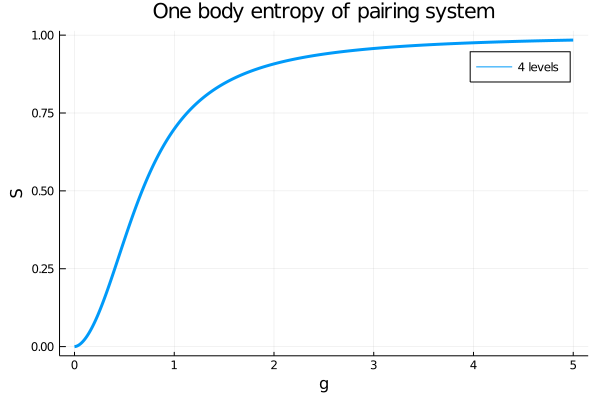

In [21]:
plot(g, entropy, title = "One body entropy of pairing system", label = "4 levels", lw = 3, xlabel = "g", ylabel = "S")

<a id='states'></a>
## States using symmetries

In the previous section, we found out the occupancies of the different levels. With this information we can recover the original state with the occupancies of each individual level.

In [22]:
d=4
nume = Int(d/2)

o = Op(d)

e0 = 1.0
epsilon = [2*e0*(i-d/2-1/2) for i in 1:d]
g = 5.0
h0 = spzeros(binomial(d,nume),binomial(d,nume))
bam = basis_m2(o,nume)

for i in 1:binomial(d,nume)
    h0[i,i] = epsilon'*bam[i,:]
end

hi = spzeros(binomial(d,nume),binomial(d,nume))
for i in 1:binomial(d,nume)
    for j in 1:binomial(d,nume)
        if length(findall(in(indx(bam[i,:])), indx(bam[j,:]))) == nume - 1
            hi[i,j] = g
        end
    end
end

h = h0 - hi;
fundamental = eigvecs(Matrix(h))[:,1]
ocup = [fundamental[i]^2 for i in 1:length(fundamental)];
n_ocup = zeros(d)
for i in 1:binomial(d,Int(d/2))
    global n_ocup = n_ocup + ocup[i]*bam[i,:]
end

d2 = 2*d
o2 = Op(d2)
vac = vacuum(o2);

len = length(bam[1,:])
len2 = length(bam[:,1])
bam2 = zeros(len2,2*len)
for j in 1:len2
    counter = 0
    for i in 1:2*len
        if i%2 != 0
            counter = counter + 1
        end
        global bam2[j,i] = bam[j,counter]
    end
end

states = zeros(2^d2)
b = Matrix(basis(o2))
for i in 1:2^d2
    for j in 1:binomial(d, nume)
        if b[i,:] == bam2[j,:]
            states[i] = fundamental[j]
        end
    end
end
states = states/sqrt(states'*states)
fundstate = State(states,o2);

In [23]:
sort(eigensp(fundstate), rev=true)

8-element Array{Float64,1}:
 0.598475566126938
 0.598475566126938
 0.534545046798091
 0.534545046798091
 0.465454953201909
 0.465454953201909
 0.401524433873062
 0.401524433873062

It is identical to the first method, where we used only fermionic operators with no symmetries. 